In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jax import random, vmap, jit
from jax.lax import scan

%config InlineBackend.figure_format='retina'

# KdV D=1

IVP

\begin{equation}
  \begin{split}
    &\frac{\partial u(x, t)}{\partial t} + \frac{\partial^3 u(x, t)} {\partial x^3} - 6 u(x, t) \frac{\partial u(x, t)}{\partial x} = 0,\\
    &u(x, 0) = u_{0}, u(1, t) = u(0, t),
  \end{split}
\end{equation}

where

\begin{equation}
  \begin{split}
    &u_0 = -\frac{c}{2\left(\cosh\left(\frac{\sqrt{c}}{2}((x - ct) - x_0)\right)\right)^2},\\
    &c\sim\mathcal{U}[c_\min, c_\max],\,x_0\sim\mathcal{U}[0, 1].
  \end{split}
\end{equation}

In [2]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_1D(key=random.PRNGKey(11), N_samples=1000, c_min = 500, c_max = 900, delta_t = 0.3*1/700, N_x=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t1 = t0 + delta_t
    features = vmap(s, in_axes=(None, 0, 0))(x, t0, c)
    targets = vmap(s, in_axes=(None, 0, 0))(x, t1, c)
    features = jnp.expand_dims(features, 1)
    targets = jnp.expand_dims(targets, 1)

    if normalize:
        features_scale = jnp.max(jnp.max(jnp.abs(features), axis=2, keepdims=True), axis=0, keepdims=True)
        targets_scale = jnp.max(jnp.max(jnp.abs(targets), axis=2, keepdims=True), axis=0, keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, jnp.expand_dims(x, 0)

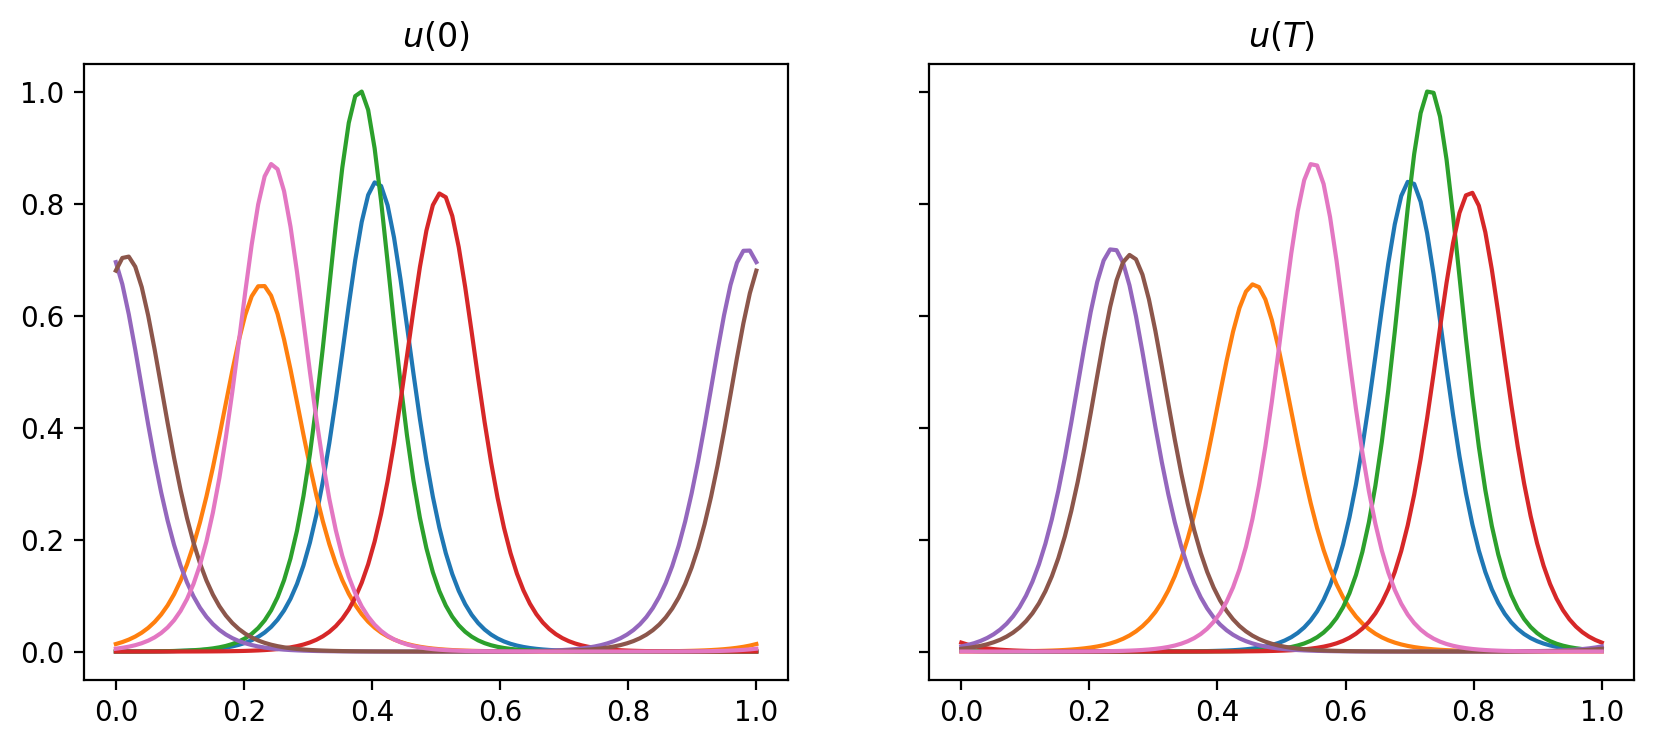

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
key = random.PRNGKey(11)
N_samples = 7
features, targets, coordinates = get_dataset_KdV_1D(key=key, N_samples=N_samples, normalize=True)

for i, field in enumerate([features, targets]):
    for j in range(N_samples):
        ax[i].plot(coordinates[0], field[j, 0])

for i, n in enumerate(["$u(0)$", "$u(T)$"]):
    ax[i].set_title(n)

# KdV D=2

In [4]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_2D(key=random.PRNGKey(11), N_samples=1000, c_min=500, c_max=900, delta_t=0.3*1/700, N_x=100, N_t=111, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t = delta_t * jnp.linspace(0, 1, N_t)
    X, T = jnp.meshgrid(x, t)
    coordinates = jnp.stack([X, T], 0)
    t = jnp.expand_dims(t, 0) + jnp.expand_dims(t0, 1)
    t = jnp.expand_dims(t, 2)
    x = jnp.expand_dims(x, 0)
    solutions = vmap(s, in_axes=(None, 0, 0))(x, t, c) # solutions.shape = (N_samples, N_t, N_x)

    features = solutions[:, :1, :]
    targets = jnp.expand_dims(solutions, 1)

    if normalize:
        features_scale = jnp.max(jnp.max(jnp.abs(features), axis=2, keepdims=True), axis=0, keepdims=True)
        targets_scale = jnp.max(jnp.max(jnp.abs(targets), axis=3, keepdims=True), axis=0, keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, coordinates

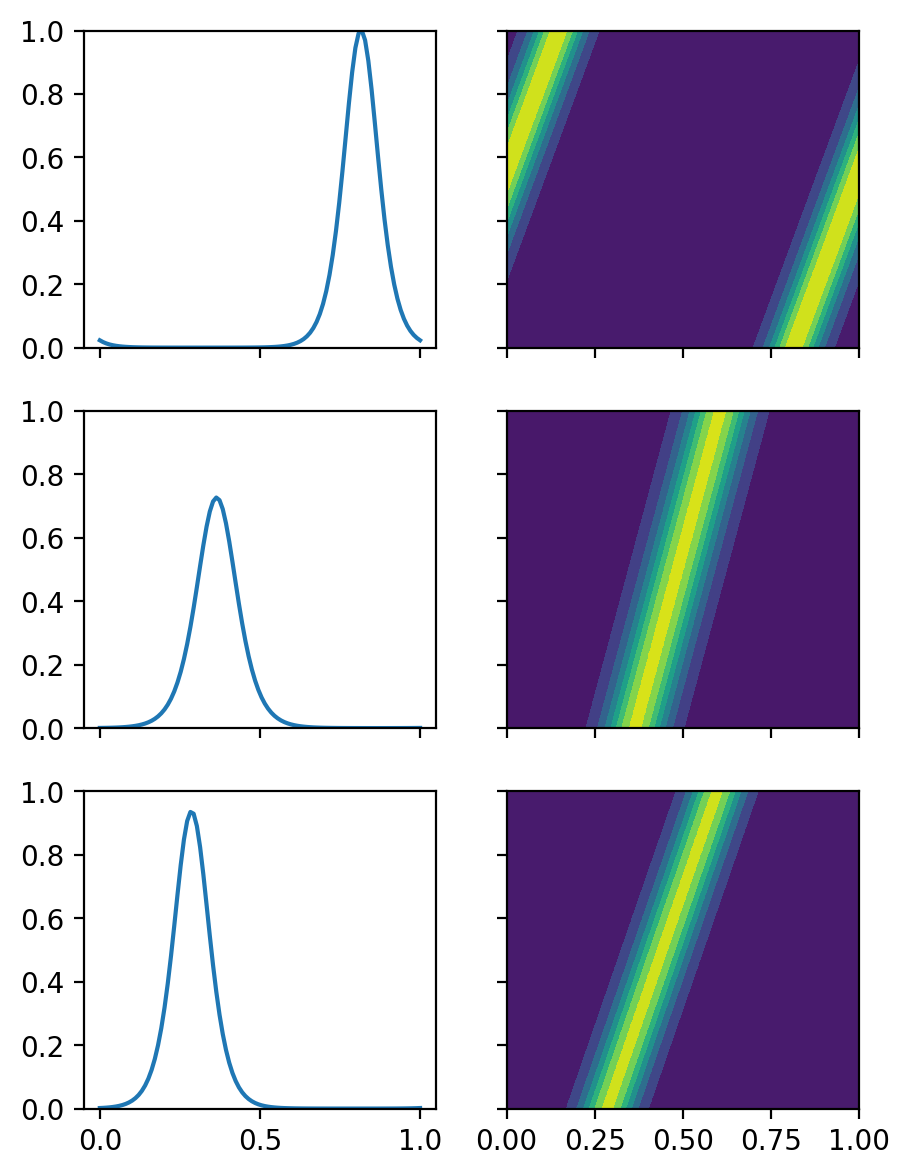

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(5, 7), sharex='col', sharey='row')

key = random.PRNGKey(1117)
N_samples = 3
features, targets, coordinates = get_dataset_KdV_2D(key=key, N_samples=N_samples, normalize=True)

for j in range(N_samples):
  ax[j, 0].plot(coordinates[0, 0], features[j, 0])

for j in range(N_samples):
  ax[j, 1].contourf(coordinates[0], coordinates[1]/jnp.max(coordinates[1]), targets[j, 0])